# 消除宇宙射线
姓名：姚明亮

班级：22天文

学号：2112219043

## 实验目的
    1、学会使用python对天文图像进行操作。
    2、观察图像分布，能够找出较好的方法处理。
    3、对天文图像处理形成初步的理解。

## 实验环境：
    1. 系统：MacOS
    2. 系统版本：13.0.1
    3. Python版本：3.9.12
    4. Numpy版本：1.22.1
    5. Pandas版本：1.4.4
    6. fits文件：jbit11e1q_flc.fits

In [1]:
## 导入相关包
%matplotlib inline
from astropy.io import fits
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from skimage.filters import threshold_mean
from skimage import color, morphology, exposure
#在MacOS系统上使matplotlib支持中文显示
plt.rcParams['font.sans-serif']='Heiti TC' 


In [2]:
# 导入文件，并查看数据部分的形状
hud = fits.open('./jbit11e1q_flc.fits')
img = hud[1].data
img.shape

(2048, 4096)

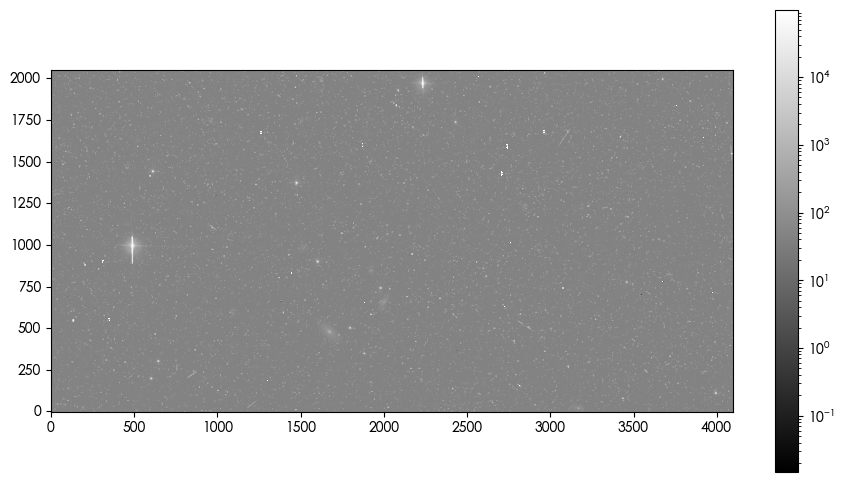

In [3]:
# 绘制，大概查看一下图像
from matplotlib.colors import LogNorm
plt.figure(figsize=(11,6))
plt.imshow(img,cmap='gray',norm=LogNorm(),origin='lower')
plt.colorbar()
plt.show()


In [4]:
# 绘制直方图，查看数据分布情况
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(img.flatten())
plt.show
plt.subplot(122)
plt.hist(img.flatten(),bins=1000,log=True)
plt.show()

In [5]:
# 对数据进行归一化后，再进行直方图均衡化，展露出图像更多的细节，给出一个更好的图像显示结果。
img_1=(img-np.min(img))/(np.max(img)-np.min(img))
p1, p98 = np.percentile(img_1, (0.1,98))
img_rescale = exposure.rescale_intensity(img_1, in_range=(p1, p98))
plt.figure(figsize=(15,4))

plt.subplot(121) 
plt.title('均衡化后的图像显示')
plt.imshow(img_rescale,cmap='gray',origin='lower')
plt.colorbar()

plt.subplot(122) 
plt.title('原图以对数函数显示')
plt.imshow(img,cmap='gray',origin='lower',norm=LogNorm())
plt.colorbar()
plt.show()

In [6]:
# 感谢师兄们的指导，采用迭代优化的方法处理全部数据，最终得到一个也是近似高斯分布的三倍标准差作为阈值。
img_1w=img.flatten()
delta=1000000

while True:
    n,bins,_=plt.hist(img_1w, bins=1000, color='black')
    mu=np.mean(img_1w)
    std=np.std(img_1w)
    
    x=(bins[1:]+bins[:-1])/2
    y=norm.pdf(x,mu,std)
    y=y/sum(y)*img_1w.size
    plt.plot(x,y,color='r')
    plt.close()
    
    error=sum(abs(y-n))/y.size
    if error<delta:
        img_1w=img_1w[img_1w<=mu+3*std]
        img_1w=img_1w[img_1w>=mu-3*std]
        delta=error
    else:
        thresh=mu+std*3
        print(thresh)
        break

81.01174449920654


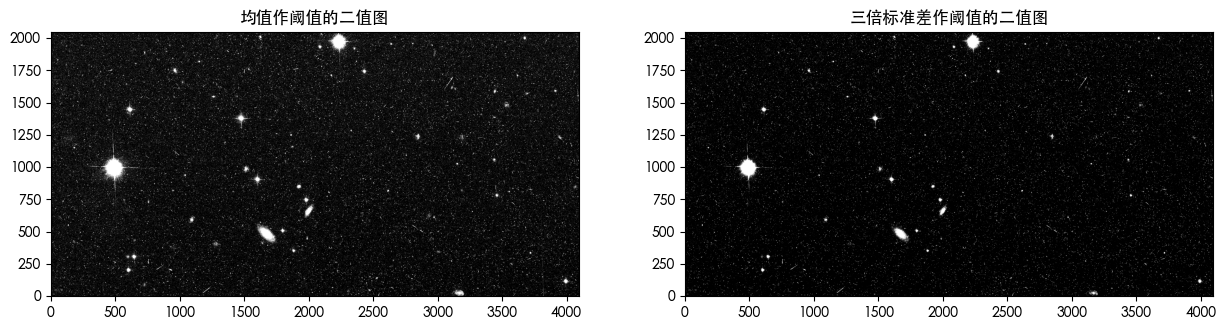

In [7]:
# 使用迭代得到的阈值对图像二值化
img_=np.empty(img.shape)
img_[img>=thresh]=1
img_[img<thresh]=0

thresh_mean=threshold_mean(img)
img_mean=np.empty(img.shape)
img_mean[img>=thresh_mean]=1
img_mean[img<thresh_mean]=0

plt.figure(figsize=(15,10))
plt.subplot(122)
plt.title('三倍标准差作阈值的二值图')
plt.imshow(img_,cmap='gray',origin='lower')
# plt.colorbar()

plt.subplot(121)
plt.title('均值作阈值的二值图')
plt.imshow(img_mean,cmap='gray',origin='lower')
plt.show()

In [8]:
# 对二值化后的图像进行开运算和闭运算
closed = morphology.closing(img_,footprint=morphology.disk(2))
opened = morphology.opening(closed ,footprint=morphology.disk(4))
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.title('闭运算处理,半径为2的圆')
plt.imshow(closed,cmap='gray',origin='lower')

plt.subplot(122)
plt.title('开运算处理,半径为4的圆')
plt.imshow(opened,cmap='gray',origin='lower')
plt.show()

In [9]:
# 原图乘以处理后的二值图，结果以对数结果显示出来
img_change_data=img_ * opened
plt.figure(figsize=(15,6))
plt.imshow(img_change_data.astype('float32')+1,cmap='gray',norm=LogNorm(),origin='lower')
plt.colorbar()
plt.show()

In [10]:
# 存储最后的图像
outfile = './Final.fits'
hdu = fits.PrimaryHDU(img_change_data)
hdu.writeto(outfile, overwrite=True)

## 结论
    1. 图像中噪声占大部分比重，且本图的噪声能量分布近似高斯分布
    2. 处理天文图像并不能用单一的方法得到很好的结果，需要多种方法结合起来使用